<h1>Does a job training program improve the earnings of disadvantaged workers?</h1>

In [117]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import math
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
from array import array


# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

<h2>Introduction</h2>

<p><strong>Business Context.</strong> In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.</p>
<p><img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training"></p>
<p>The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.</p>
<p><strong>Business Problem.</strong> Your goal is to evaluate <strong>whether the job training program <em>causes</em> the earnings of disadvantaged workers to go up</strong>.</p>
<p><strong>Analytical Context.</strong> In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.</p>

<h2>Examining the data</h2>
<p>The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is <code>re78</code> in which we want to know if there was an increase in earnings in 1978:</p>
<ol>
<li><strong>age</strong>: age in years</li>
<li><strong>educ</strong>: years of schooling</li>
<li><strong>black</strong>: indicator variable for blacks</li>
<li><strong>hisp</strong>: indicator variable for Hispanics</li>
<li><strong>married</strong>: indicator variable for martial status</li>
<li><strong>nodegr</strong>: indicator variable for high school diploma</li>
<li><strong>re74</strong>: real earnings in 1974</li>
<li><strong>re75</strong>: real earnings in 1975</li>
<li><strong>re78</strong>: real earnings in 1978 - this is the outcome of interest</li>
<li><strong>treat</strong>: an indicator variable for treatment status</li>
</ol>

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


<h3>Exercise 1:</h3>
<h4>1.1</h4>
<p>Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?</p>

**Answer.**

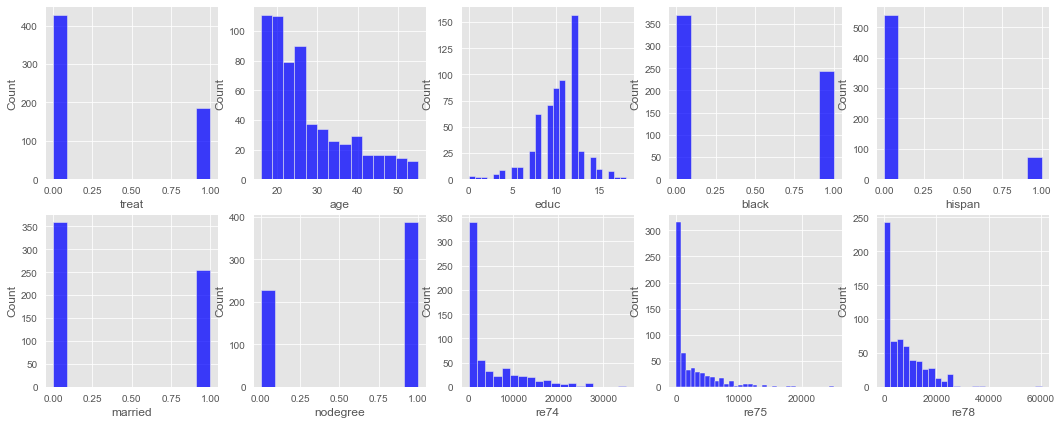

In [3]:
#Antes de obtener las estadisticas resumidas vamos a observar la distribución de los valores dentro de cada variable
columns = list(lalonde_df.columns)

plt.figure(figsize=(18,7))
    
for i,column in enumerate(columns):
    plt.subplot(2,5,i+1)
    sns.histplot(x= column, color='b', data=lalonde_df)  


***It can quickly be observed in the records, the third part did not take the treatment, that there are few Hispanics in the sample, additionally that the program was applied in its vast majority to people who had not obtained an educational degree.***

In [4]:
# A continuación se presenta el resumen estadistico de las variables.
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


<h4>1.2</h4>
<p>What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?</p>
<p><strong>Note:</strong> Remember that the <em>treatment and control groups</em> correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  <code>treat</code> column.</p>

**Answer.**

In [5]:
treatment_group = lalonde_df.groupby('treat')['re78'].agg(['median','mean'])
treatment_group['perct_%']= round(lalonde_df.groupby('treat')['re78'].agg(['count']) / len(lalonde_df)*100,2)

print(treatment_group)

# Para validar si la diferencia entre el tomar el tratamiento o no es significativo para los ingresos obtenidos en 1978
# realizamos una prueba T con el fin de validar si las dos muestras son diferentes

a = lalonde_df[lalonde_df['treat'] == 0]['re78']
b = lalonde_df[lalonde_df['treat'] == 1]['re78']

print()
print('*******--------Prueba T-------********')
print()
T,p=ttest_ind(a,b)

print('P values es:', p)


         median         mean  perct_%
treat                                
0      4975.505  6984.169742    69.87
1      4232.309  6349.143530    30.13

*******--------Prueba T-------********

P values es: 0.3342496685909654


***approximately 30% of the workers are in the program, in relation to income it is observed that those who do not take the treatment have a higher average income. Which is contrary to what would be expected.*** 

***Since the p -value is high> 0.05,. This tells us that treatment is not a significant factor when it comes to estimating earnings in 1978.***

<h4>1.3</h4>
<p>Does your previous result mean that the treatment had a negative impact? Why or why not?</p>

**Answer.**

***The above results suggest that the treatment did not really have any impact on earnings in 1978.***

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

<h3>Exercise 2:</h3>
<h4>2.1</h4>
<p>Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?</p>

**Answer.**

In [6]:
# Para validar si los grupos de tratamiento y control tienen distribuciones similares
variables = ['age','educ','re74','re75']

for var in variables:
    name = f'treatment_group_{var}'
    name = lalonde_df.groupby('treat')[var].agg(['mean','var'])
    print(f'------Tabla de contingencia de media y varianza {var} ---------')
    print(name)
    dif_mean = (name.iloc[0][0] - name.iloc[1][0])
    sqr_var = math.sqrt((name.iloc[0][1]**2 + name.iloc[1][1]**2)/2)
    SMD = dif_mean / sqr_var
    print()
    print(f'SMD {var} is:', SMD )
    print()


------Tabla de contingencia de media y varianza age ---------
            mean         var
treat                       
0      28.030303  116.351883
1      25.816216   51.194301

SMD age is: 0.024632446443708163

------Tabla de contingencia de media y varianza educ ---------
            mean       var
treat                     
0      10.235431  8.152387
1      10.345946  4.042714

SMD educ is: -0.01717540344582962

------Tabla de contingencia de media y varianza re74 ---------
              mean           var
treat                           
0      5619.236506  4.608714e+07
1      2095.573689  2.387906e+07

SMD re74 is: 9.600452701421581e-05

------Tabla de contingencia de media y varianza re75 ---------
              mean           var
treat                           
0      2466.484443  1.083724e+07
1      1532.055314  1.036358e+07

SMD re75 is: 8.812831051666561e-05



***For age and education, the treatment and control groups have the same distribution, not the same for the income groups in 1974 and 1975.***

<h4>2.2</h4>
<p>Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.</p>

**Answer.**

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

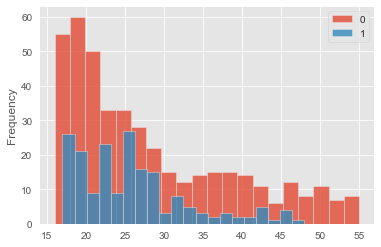

In [7]:
lalonde_df.groupby('treat')['age'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: educ, dtype: object

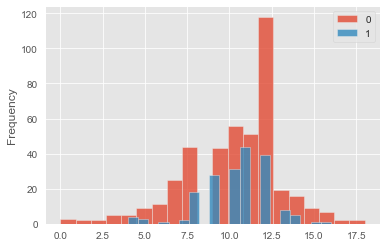

In [8]:
lalonde_df.groupby('treat')['educ'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: re74, dtype: object

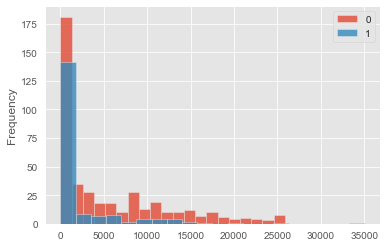

In [9]:
lalonde_df.groupby('treat')['re74'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

treat
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: re75, dtype: object

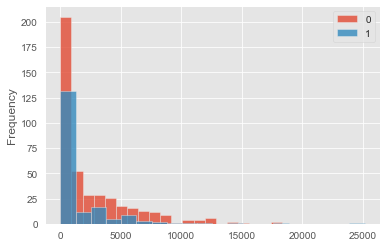

In [10]:
lalonde_df.groupby('treat')['re75'].plot(kind='hist', bins=20, alpha=0.8, legend=True)

<h2>Propensity score matching using logistic regression</h2>

<p>In order to balance the covariates of the control and treatment groups, we will use <strong>matching</strong>. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.</p>
<p>In Case 7.5 we used the <em>Euclidean distance</em> on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.</p>
<p>We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the <strong>propensity score</strong> helps us do the matching on select features in an efficient way. The key idea is that <em>the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results</em>. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:</p>
<p>$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)</p>
<p>As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.</p>

<h3>Exercise 3:</h3>
<h4>3.1</h4>
<p>Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. How would you interpret the predicted values output by the model? </p>

**Answer.**

In [11]:
#Antes de generar el modelo de regresion logistica es importante normalizar los datos

df2 = lalonde_df.copy()

var_names=['age','educ','re74','re75']
for var in var_names:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()

df2

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,9930.0460
NSW2,1,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,3595.8940
NSW3,1,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,24909.4500
NSW4,1,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,7506.1460
NSW5,1,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,289.7899
...,...,...,...,...,...,...,...,...,...,...
PSID425,0,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,10150.5000
PSID426,0,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,19464.6100
PSID427,0,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0.0000
PSID428,0,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,187.6713


In [12]:
# Antes obtener el modelo de regresion logistica, agregamos el campo con el intercepto a los datos
df_log = df2[['age','educ','black','hispan','married','nodegree','re74','re75','treat']]
df_log ['Intercept'] = 1
df_log

,age,educ,black,hispan,married,nodegree,re74,re75,treat,Intercept
NSW1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,1,1
NSW2,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,1,1
NSW3,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,1,1
NSW4,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,1,1
NSW5,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,1,1
...,...,...,...,...,...,...,...,...,...,...
PSID425,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,0,1
PSID426,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,0,1
PSID427,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0,1
PSID428,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,0,1


In [13]:
# Obtener un modelo de regresión logística usando la función Logit de statsmodels
model_logit = sm.Logit(df_log['treat'], df_log[['Intercept','age','educ','black','hispan','married','nodegree','re74','re75']])
logit_res = model_logit.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.3508
Time:                        02:16:24   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8509      0.350     -8.147      0.000      -3.537      -2.165
age            0.1559      0.134      1.162      0.245      -0.107       0.419
educ           0.4240      0.171      2.477      0.013       0.088       0.759
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74          -0.4650      0.186     -2.497      0.013      -0.830      -0.100
re75           0.1761      0.153      1.153      0.249      -0.123       0.476
==============================================================================
"""

***According to the analysis of the p-values, the variables of age and income from 1975 are not associated with the probability that the person has taken the treatment, since their value is > 0.05*** 

***Additionally, the fact that the person has more years of study, is black or Hispanic and has abandoned their studies increases the probability of having taken the treatment. While being married and the income obtained in 1974 negatively impact the probability of having taken the treatment.***




<h4>3.2</h4>
<p>Use <code>.predict()</code>  to obtain the propensity scores of individuals in our dataset. Save the the results with the name <code>pscore_logit</code> (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.</p>

**Answer.**

In [14]:
# La serie predict_withvs contiene las probabilidades calculadas por nuestro modelo logístico.  
# los valores más cercanos a 1 corresponden a personas que probablemente tomaron el tratamiento.

pscore_logit = logit_res.predict(df_log[['Intercept','age','educ','black','hispan','married','nodegree','re74','re75']])
df_log['score'] = pscore_logit
print(pscore_logit.head(5))
df_log

NSW1    0.638770
NSW2    0.224634
NSW3    0.678244
NSW4    0.776324
NSW5    0.701639
dtype: float64


,age,educ,black,hispan,married,nodegree,re74,re75,treat,Intercept,score
NSW1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,1,1,0.638770
NSW2,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,1,1,0.224634
NSW3,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,1,1,0.678244
NSW4,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,1,1,0.776324
NSW5,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,1,1,0.701639
...,...,...,...,...,...,...,...,...,...,...,...
PSID425,-0.947578,0.278227,0,0,0,1,-0.703546,-0.662971,0,1,0.123144
PSID426,-0.340363,-3.526478,0,1,1,1,-0.703546,-0.662971,0,1,0.034560
PSID427,-0.643970,2.941520,0,0,0,0,-0.703546,-0.662971,0,1,0.183351
PSID428,0.469256,-2.004596,1,0,1,1,-0.703546,-0.662971,0,1,0.383032


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


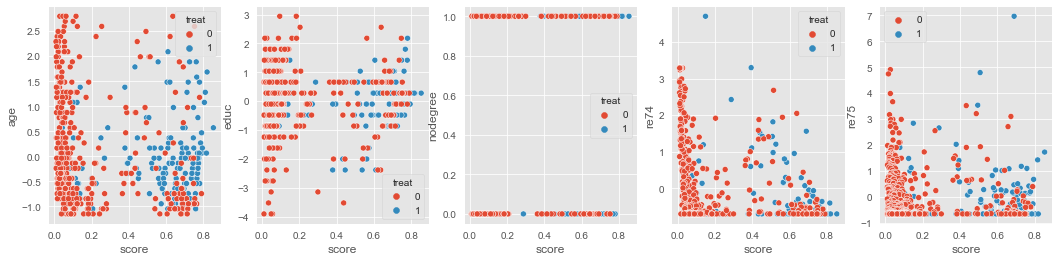

In [15]:
fig,ax = plt.subplots(1,5,figsize=(18,4))
sns.scatterplot(x='score',y='age',hue='treat',data=df_log, ax=ax[0])
plt.legend()
sns.scatterplot(x='score',y='educ',hue='treat',data=df_log, ax=ax[1])
plt.legend()
sns.scatterplot(x='score',y='nodegree',hue='treat',data=df_log, ax=ax[2])
plt.legend()
sns.scatterplot(x='score',y='re74',hue='treat',data=df_log, ax=ax[3])
plt.legend()
sns.scatterplot(x='score',y='re75',hue='treat',data=df_log, ax=ax[4])
plt.legend()

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

<h3>Exercise 4 :</h3>
<p>In this exercise, we will use the <code>sklearn.neighbors</code> function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors"><code>NearestNeighbors</code></a> to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.</p>
<h4>4.1</h4>
<p>Separate the propensity scores <code>pscore_logit</code> found in Exercise 3 for treatment and control groups. Call these <code>treat_pscores</code> and <code>control_pscores</code> respectively. Use the <code>control_pscores</code> to train a $k$-NN algorithm with $k=5$.</p>
<p><strong>Hint:</strong> Load the model using <code>knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')</code>. You may want to reshape the control scores using <code>control_pscores.reshape(-1,1)</code>.</p>

**Answer.**

In [16]:
'''
El procedimiento de emparejamiento o maching se utiliza para seleccionar una submuestra con el fin de disminuir
desequilibrios entre los grupos, con el objetivo de conseguir homogenoidad entre los grupos de estudio, minimizando 
de esa manera la posibilidad de confusión.

Una prueba para medir la efectividad del matching es la Diferncia de Medias Estandarizada (SMD) para cada covariable
entre grupos.
'''

# Separamos los score obtenidos en el ejercicio anterior en grupos de tratamiento y control

# tratamiento 
treat_pscores = np.array(pscore_logit.filter(like='NSW',axis=0))
treat_pscores = treat_pscores.reshape(-1,1)
# Control
control_pscores = np.array(pscore_logit.filter(like='PSID',axis=0))
control_pscores = control_pscores.reshape(-1,1)

#Aplicamos Knn
knn = NearestNeighbors(n_neighbors=5,metric='euclidean')
knn.fit(control_pscores)
print((knn.kneighbors(control_pscores)[1]).shape)
print(knn.kneighbors(control_pscores))


(429, 5)
(array([[0.00000000e+00, 3.41954898e-05, 7.09229077e-05, 1.13347132e-04,
        2.78808988e-04],
       [0.00000000e+00, 2.62763107e-05, 2.14841128e-04, 3.04261081e-04,
        3.70721699e-04],
       [0.00000000e+00, 7.91516425e-05, 1.13347132e-04, 1.65461856e-04,
        1.84270040e-04],
       ...,
       [0.00000000e+00, 1.53221405e-04, 3.21058560e-04, 4.05048607e-04,
        1.30698413e-03],
       [0.00000000e+00, 1.15632212e-03, 2.12967810e-03, 5.93005941e-03,
        9.46596542e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.03885042e-04]]), array([[  0, 256,  60,   2, 194],
       [  1, 253, 116, 232, 129],
       [  2, 256,   0, 194,  60],
       ...,
       [426, 416, 240, 263, 409],
       [427,  83, 259,  58,  40],
       [428, 376, 421, 396, 331]], dtype=int64))


<h4>4.2</h4>
<p>Find the indices of the five nearest neighbors using the method <code>.kneighbors()</code> applied to <code>treat_pscores</code>. </p>

**Answer.**

In [17]:
# Lo anterior devuelve la distancia a la que se encuentra el score mas cercano y la posición del elemento en la muestra
index = knn.kneighbors(treat_pscores)
print(index[1].shape)
print(index[1])

(185, 5)
[[ 68 386 372 385 375]
 [110  65 338 149 198]
 [369 188 267 380 354]
 [225 195 117 387 411]
 [139 133 276 217 371]
 [217 139 371 415 325]
 [255  14 233 367 351]
 [117 225 195 387 411]
 [225 117 195 387 411]
 [343 108  91 177 293]
 [268 172 325 415 265]
 [380 267 354 188 252]
 [367 351 255 375 397]
 [216 290  47 332 227]
 [334 336 109 277 156]
 [410 366 400 391 399]
 [139 133 276 217 371]
 [398 178 157 329 422]
 [405 276 399 400 391]
 [344 407 374 233  14]
 [195 387 411 225 230]
 [229 176 126  99 219]
 [181 206 424 404 273]
 [195 225 387 411 230]
 [410 366 391 400 399]
 [334 336 109 277 156]
 [195 225 387 117 411]
 [135  16 294 270 226]
 [391 400 399 366 410]
 [195 225 387 411 230]
 [391 400 399 366 410]
 [334 336 109 277 156]
 [158 277 109 334 336]
 [385 372 375 397  68]
 [344 233  14 255 407]
 [225 117 195 387 411]
 [216 290  47 332 227]
 [ 97 353  93 355  98]
 [216 290  47 332 227]
 [178 157 398 329 422]
 [375 397 351 367 385]
 [274  85 140 202  88]
 [375 397 351 367 385]
 [

<h4>4.3</h4>
<p>Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of <code>DataFrames</code>, each with $185$ rows from the <code>lalonde_df</code>. The first should correspond to the treatment group and the second should correspond to the matched control group.</p>

**Answer.**

In [49]:
#Determinamos el primer dataframe solo con los registros de las personas que hacen parte del grupo de entrenamiento.

group_treat = df2[df_log['treat']==1]
group_treat

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,0.975268,0.278227,1,0,1,1,-0.703546,-0.662971,9930.0460
NSW2,1,-0.542768,-0.482714,0,1,0,1,-0.703546,-0.662971,3595.8940
NSW3,1,0.266851,0.658697,1,0,0,0,-0.703546,-0.662971,24909.4500
NSW4,1,-0.036756,0.278227,1,0,0,1,-0.703546,-0.662971,7506.1460
NSW5,1,0.570459,-0.863185,1,0,0,1,-0.703546,-0.662971,289.7899
...,...,...,...,...,...,...,...,...,...,...
NSW181,1,0.570459,0.658697,1,0,1,0,2.427059,2.656937,15952.6000
NSW182,1,-0.239161,1.419638,1,0,1,0,4.705571,2.837543,36646.9500
NSW183,1,0.772863,-0.482714,1,0,1,1,1.396254,3.533627,12803.9700
NSW184,1,0.772863,-0.863185,1,0,1,1,1.416266,4.791490,3786.6280


In [50]:
index_control=pd.read_csv('index_control.csv')
index = index_control['Index']
df3 = df2.copy()
df3['g_control'] = df3.index.isin(index)
group_control = df3[df3['g_control']==True]
group_control = group_control.drop(['g_control'],axis=1)
group_control

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
PSID5,0,-0.239161,-0.482714,1,0,1,1,1.585705,3.517209,0.0000
PSID6,0,0.975268,-0.482714,1,0,1,1,1.409074,3.207567,17833.2000
PSID8,0,-0.745173,0.658697,1,0,0,0,0.437602,3.098376,17765.2300
PSID15,0,-0.542768,1.419638,1,0,1,0,-0.588010,2.706705,18208.5500
PSID24,0,1.987292,-0.863185,1,0,1,1,0.728257,1.929339,0.0000
...,...,...,...,...,...,...,...,...,...,...
PSID412,0,2.594507,0.658697,1,0,0,0,-0.703546,-0.662971,0.0000
PSID416,0,0.671661,0.658697,1,0,0,0,-0.703546,-0.662971,0.0000
PSID419,0,2.392102,-2.385067,1,0,0,1,-0.703546,-0.662971,0.0000
PSID423,0,-0.036756,-0.102244,1,0,0,1,-0.703546,-0.662971,7543.7940


<h3>Propensity score distribution plot after matching</h3>
<p>Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.</p>

<h3>Exercise 5 :</h3>
<p>Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.</p>

**Answer.**

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


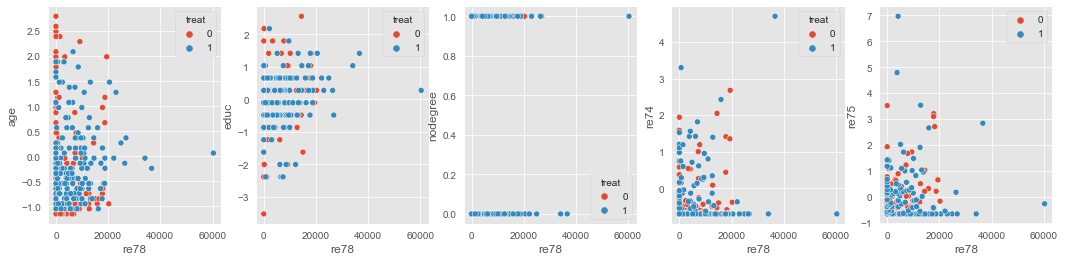

In [52]:
#Concatenamos los dos dataframe con el emparejamiento
frames = [group_control,group_treat]
df_match = pd.concat(frames)
df_match
#Graficamos la distribucion de las covariables en funcion del score
fig,ax = plt.subplots(1,5,figsize=(18,4))
sns.scatterplot(x='re78',y='age',hue='treat',data=df_match, ax=ax[0])
plt.legend()
sns.scatterplot(x='re78',y='educ',hue='treat',data=df_match, ax=ax[1])
plt.legend()
sns.scatterplot(x='re78',y='nodegree',hue='treat',data=df_match, ax=ax[2])
plt.legend()
sns.scatterplot(x='re78',y='re74',hue='treat',data=df_match, ax=ax[3])
plt.legend()
sns.scatterplot(x='re78',y='re75',hue='treat',data=df_match, ax=ax[4])
plt.legend()

***In the graphs of the covariates, it is observed that only those control values that are very close to the treatment values are preserved, achieving a certain homogeneity between the study groups.***

<h3>Exercise 6 :</h3>

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [53]:
# Para validar si los grupos de tratamiento y control tienen distribuciones similares
variables2 = ['age','educ','re74','re75']

for var in variables2:
    name = f'treatment_group_{var}'
    name = df_match.groupby('treat')[var].agg(['mean','var'])
    print(f'------Tabla de contingencia de media y varianza {var} ---------')
    print(name)
    dif_mean = (name.iloc[0][0] - name.iloc[1][0])
    sqr_var = math.sqrt((name.iloc[0][1]**2 + name.iloc[1][1]**2)/2)
    SMD = dif_mean / sqr_var
    print()
    print(f'SMD {var} is:', SMD )
    print()


------Tabla de contingencia de media y varianza age ---------
           mean       var
treat                    
0     -0.106391  1.270511
1     -0.156558  0.524328

SMD age is: 0.05161838067543586

------Tabla de contingencia de media y varianza educ ---------
           mean       var
treat                    
0      0.065303  1.035906
1      0.029379  0.585214

SMD educ is: 0.04270098527388141

------Tabla de contingencia de media y varianza re74 ---------
           mean       var
treat                    
0     -0.343713  0.445683
1     -0.380053  0.569036

SMD re74 is: 0.07110391237004143

------Tabla de contingencia de media y varianza re75 ---------
           mean       var
treat                    
0     -0.118382  0.769409
1     -0.198103  0.954157

SMD re75 is: 0.09198016394994765



***All SMD values are <0.1, indicating that there is homogeneity between the groups, thus minimizing the probability of confusion.***

<h3>Exercise 7 :</h3>
<p>Estimate the average effect of treatment on <font color='red'> wages (<code>re78</code>) </font> after matching. What do you conclude?</p>

**Answer.**

In [55]:
#Estimamos el efecto del emparejamiento de las muestras en los ingresos de 1978
treatment_group = df_match.groupby('treat')['re78'].agg(['median','mean'])
treatment_group['perct_%']= round(df_match.groupby('treat')['re78'].agg(['count']) / len(df_match)*100,2)

print(treatment_group)

         median        mean  perct_%
treat                               
0      2284.565  5006.74103    37.07
1      4232.309  6349.14353    62.93


***Now it is observed that the average income of those who took the treatment increased in 1978, which is in line with the logic***

<h2>Propensity score matching using decision trees and random forests</h2>

<h3>Exercise 8 :</h3>
<p>To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.</p>

<h4>8.1</h4>
<p>Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except <code>re78</code>. Use the <code>sklearn.tree</code> function <code>DecisionTreeRegressor(max_depth=4)</code> and call the new propensity scores <code>pscore_tree</code>.</p>

**Answer.**

In [62]:
# El dataframe a utilizar es df_match el cual contiene los registros que resultaron del emparejamiento
print(df_match.shape)
df_match.head(5)

(294, 10)


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
PSID5,0,-0.239161,-0.482714,1,0,1,1,1.585705,3.517209,0.00
PSID6,0,0.975268,-0.482714,1,0,1,1,1.409074,3.207567,17833.20
PSID8,0,-0.745173,0.658697,1,0,0,0,0.437602,3.098376,17765.23
PSID15,0,-0.542768,1.419638,1,0,1,0,-0.588010,2.706705,18208.55
PSID24,0,1.987292,-0.863185,1,0,1,1,0.728257,1.929339,0.00


In [105]:
#Definimos el set de datos a utilizar en nuestro modelo
df_match_tree = df_match.copy()

#Definimos las carateristicas que va a tener el modelo de Arbol de Decisiones
model_tree = DecisionTreeClassifier(max_depth = 4)

# Entrenar el clasificador de árbol de decisión
covariates=['age','educ','black','hispan','married','nodegree','re74','re75']

model_tree = model_tree.fit(df_match_tree[covariates], df_match_tree['treat'])

In [106]:
pscore_tree = model_tree.predict(df_match_tree[covariates])
df_match_tree['score'] = pscore_tree
df_match_tree

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
PSID5,0,-0.239161,-0.482714,1,0,1,1,1.585705,3.517209,0.000,1
PSID6,0,0.975268,-0.482714,1,0,1,1,1.409074,3.207567,17833.200,0
PSID8,0,-0.745173,0.658697,1,0,0,0,0.437602,3.098376,17765.230,1
PSID15,0,-0.542768,1.419638,1,0,1,0,-0.588010,2.706705,18208.550,0
PSID24,0,1.987292,-0.863185,1,0,1,1,0.728257,1.929339,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...
NSW181,1,0.570459,0.658697,1,0,1,0,2.427059,2.656937,15952.600,1
NSW182,1,-0.239161,1.419638,1,0,1,0,4.705571,2.837543,36646.950,1
NSW183,1,0.772863,-0.482714,1,0,1,1,1.396254,3.533627,12803.970,1
NSW184,1,0.772863,-0.863185,1,0,1,1,1.416266,4.791490,3786.628,1


<h4>8.2</h4>
<p>Plot the decision tree regressor using the code</p>
<div class="codehilite"><pre><span></span><code><span class="err">fig = plt.gcf()</span>
<span class="err">fig.set_size_inches(150, 100)</span>
<span class="err">tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)</span>
<span class="err">fig.savefig(&#39;tree.png&#39;)</span>
</code></pre></div>


<p>Replace <code>dt</code> with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)</p>

**Answer.**

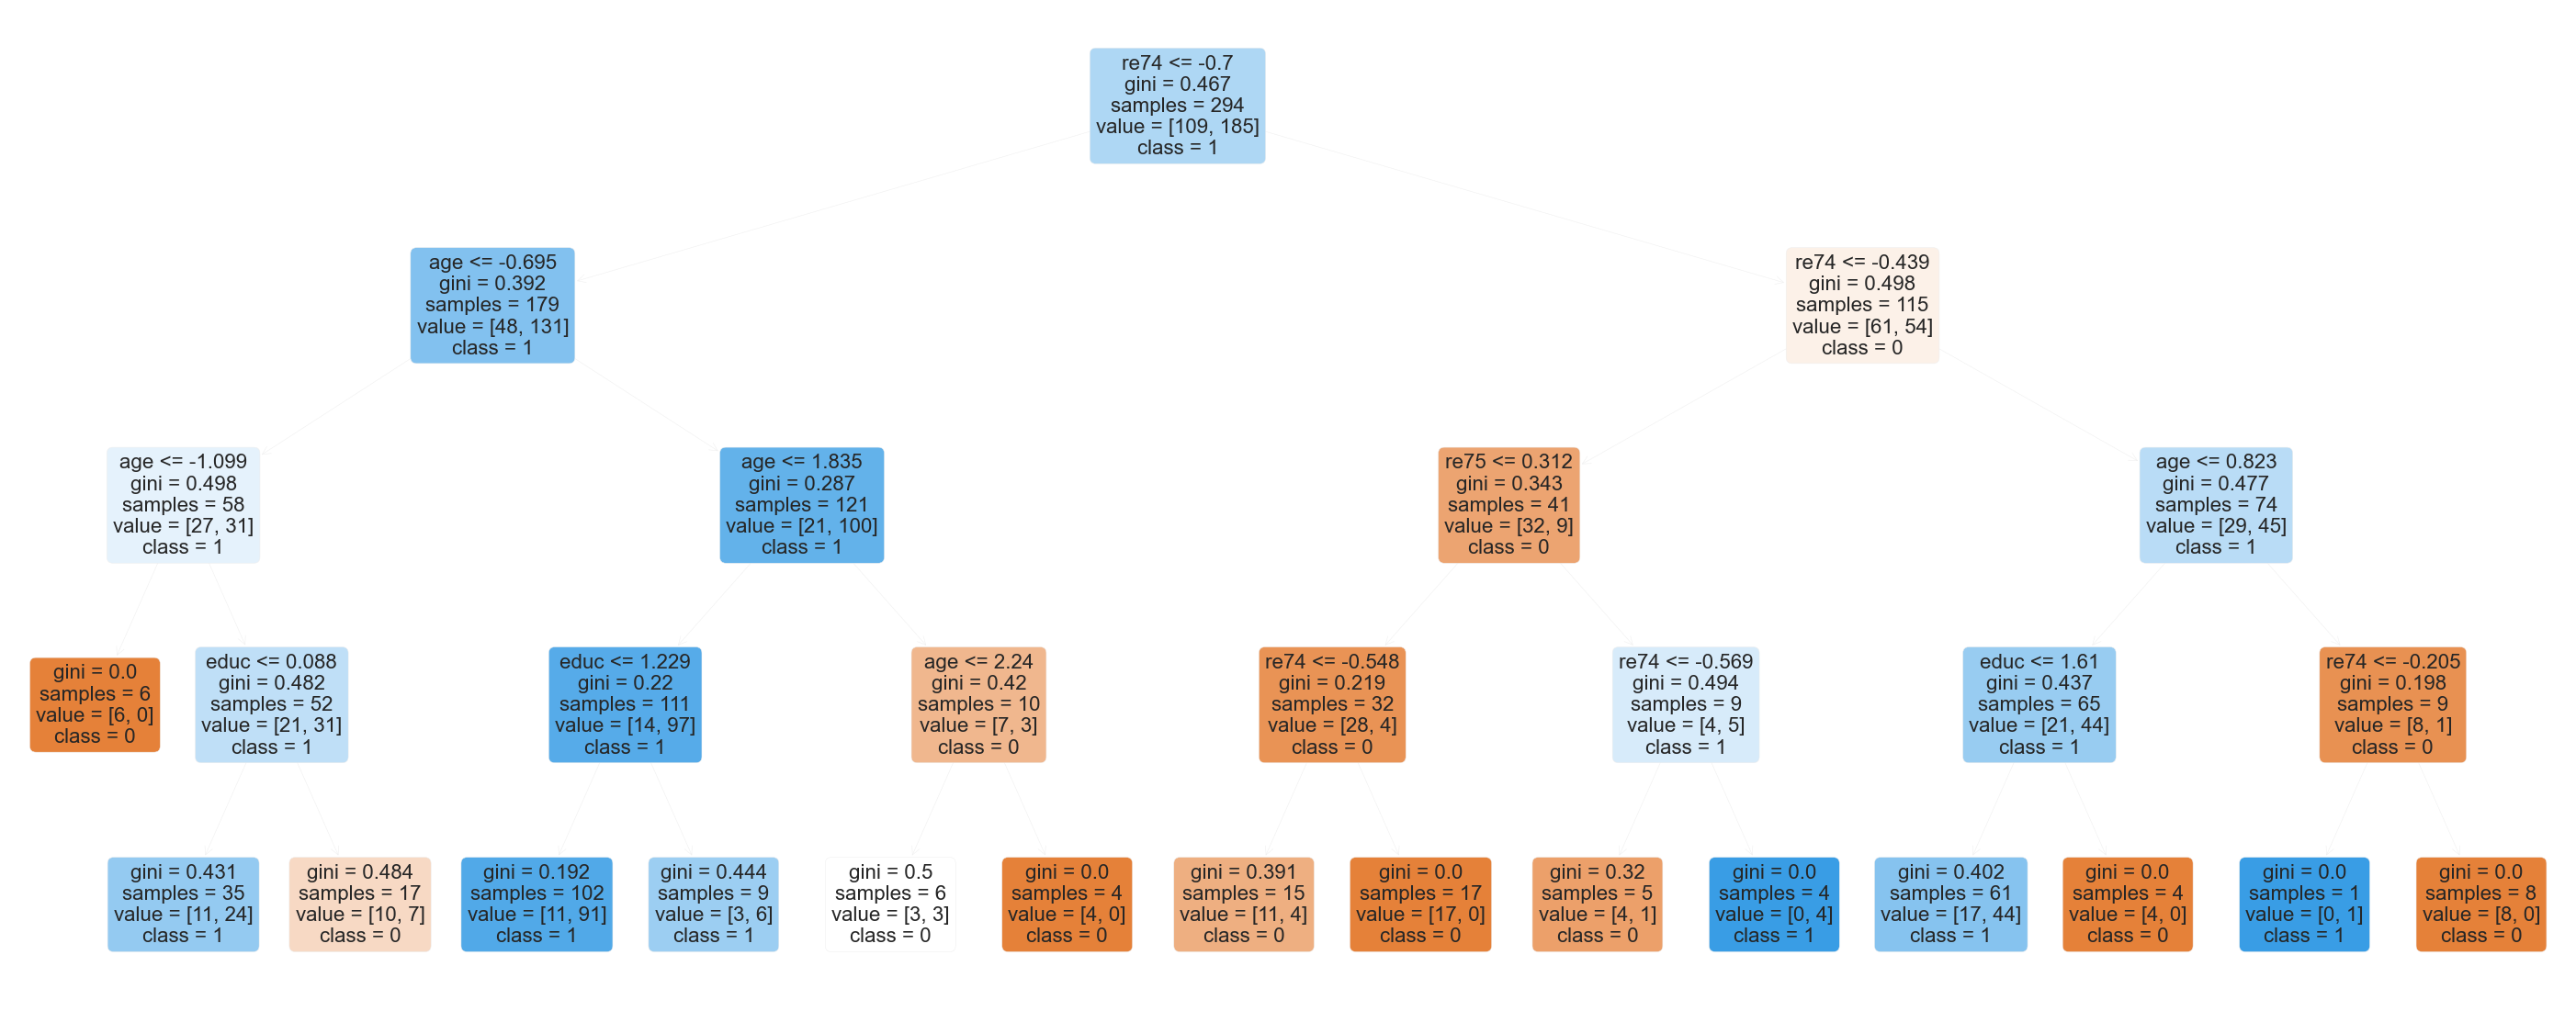

In [107]:
# Graficamos el arbol de decision
fig = plt.gcf()
fig.set_size_inches(50,20)
tree.plot_tree(model_tree,filled=True,feature_names=covariates,\
              class_names=['0','1'], rounded= True)
plt.plot(linestyle='solid',linewidth=5, markersize=12)
fig.savefig('tree.png')

<h4>8.3</h4>
<p>Estimate the propensity scores now by using random forests. For the model, use the <code>sklearn.ensemble</code> function <code>RandomForestClassifier</code> with parameters <code>n_estimators=100, max_depth=4, random_state=42</code>. Then, use the method <code>predict_proba</code> to extract the propensity scores. Name the scores <code>pscore_forest</code>.</p>

**Answer.**

In [113]:
#Definimos el set de datos a utilizar
df_match_rf = df_match.copy()

#Definimos los parameros del modelo y procedemos con el entrenamiento
model_rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
model_rf.fit(df_match_rf[covariates], df_match_rf['treat'])
pscore_forest = model_rf.predict_proba(df_match_rf[covariates])

#Adicionamos la columna con los score al dataset
df_match_rf['score'] = pscore_forest
df_match_rf

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
PSID5,0,-0.239161,-0.482714,1,0,1,1,1.585705,3.517209,0.000,0.383299
PSID6,0,0.975268,-0.482714,1,0,1,1,1.409074,3.207567,17833.200,0.474861
PSID8,0,-0.745173,0.658697,1,0,0,0,0.437602,3.098376,17765.230,0.493652
PSID15,0,-0.542768,1.419638,1,0,1,0,-0.588010,2.706705,18208.550,0.569256
PSID24,0,1.987292,-0.863185,1,0,1,1,0.728257,1.929339,0.000,0.598430
...,...,...,...,...,...,...,...,...,...,...,...
NSW181,1,0.570459,0.658697,1,0,1,0,2.427059,2.656937,15952.600,0.410509
NSW182,1,-0.239161,1.419638,1,0,1,0,4.705571,2.837543,36646.950,0.453127
NSW183,1,0.772863,-0.482714,1,0,1,1,1.396254,3.533627,12803.970,0.330101
NSW184,1,0.772863,-0.863185,1,0,1,1,1.416266,4.791490,3786.628,0.330621


<h4>8.4</h4>
<p>Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model <em>seems</em> to do the best job?</p>

**Answer.**

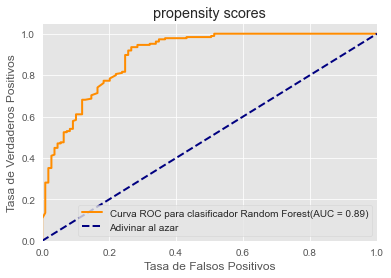

In [143]:

#roc_t = roc_curve(df_match_tree['treat'], pscore_tree[:,1])
roc_f = roc_curve(df_match_rf['treat'], pscore_forest[:,1])
#roc_l = roc_curve(df_log['treat'], pscore_logit[:,1])

#auc_t = auc( roc_t[0], roc_t[1] )
auc_f = auc_f = auc( roc_f[0], roc_f[1] )
#auc_l = auc( roc_l[0], roc_l[1] )

plt.figure()
line_width = 2

#plt.plot(roc_t[0], roc_t[1], color='green', lw=line_width,
         #label=f"Curva ROC para clasificador Desicion Tree(AUC = {auc_t:0.2f})")
plt.plot(roc_f[0], roc_f[1], color='darkorange', lw=line_width,
         label=f"Curva ROC para clasificador Random Forest(AUC = {auc_f:0.2f})")
#plt.plot(roc_f[0], roc_f[1], color='blue', lw=line_width,
         #label=f"Curva ROC para clasificador Logistic Regression(AUC = {auc_f:0.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Adivinar al azar')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('propensity scores')
plt.legend(loc='lower right')
plt.show()

<h4>8.5</h4>
<p>Consider the following statement:</p>
<blockquote>
<p>"<em>A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.</em>"</p>
</blockquote>
<p>Is the statement true or false? Explain. </p>

**Answer.**

-------

<h4>8.6</h4>
<p>Repeat the matching procedure now with the estimated propensity scores <code>pscore_tree</code> and <code>pscore_forest</code>. Assess the covariate balances and estimate the average effect of treatment on wages (<code>re78</code>) after matching. Compare your results. </p>

**Answer.**

-------

<h4>8.7</h4>
<p>Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  </p>
<p><strong>Hint:</strong> Look at the distances of the ten nearest neighbors output by <code>.kneighbors()</code> for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?</p>

**Answer.**

-------